In [1]:
from stellargraph.data import EdgeSplitter
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import plot
import common_functions as cf

In [2]:
G, mapper, reverse_mapper = cf.create_mapping_from_file_path('facebook/0.edges')

edge_splitter = EdgeSplitter(G)
splitted_graph, X, y = edge_splitter.train_test_split(p=0.2, method="global")

embedding_all = cf.node2vec_embedding(splitted_graph, "Graph") # TODO: Megkérdezni valaki, hogy G-vel miért nem működik, nem értem

model = cf.train_link_prediction_model(X, y, embedding_all, cf.operator_l2)

predictions = cf.create_result_df(splitted_graph, model, embedding_all, cf.operator_l2)

** Sampled 503 positive and 503 negative edges. **
Number of random walks for 'Graph': 33300


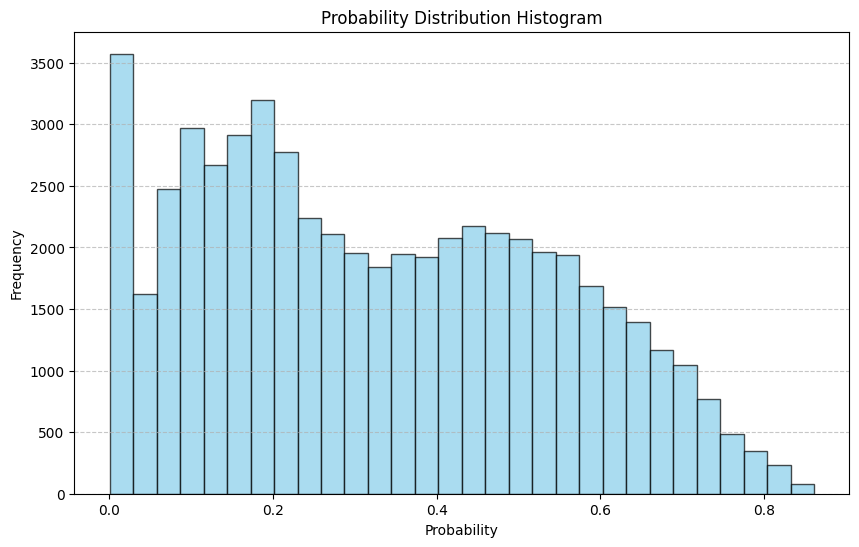

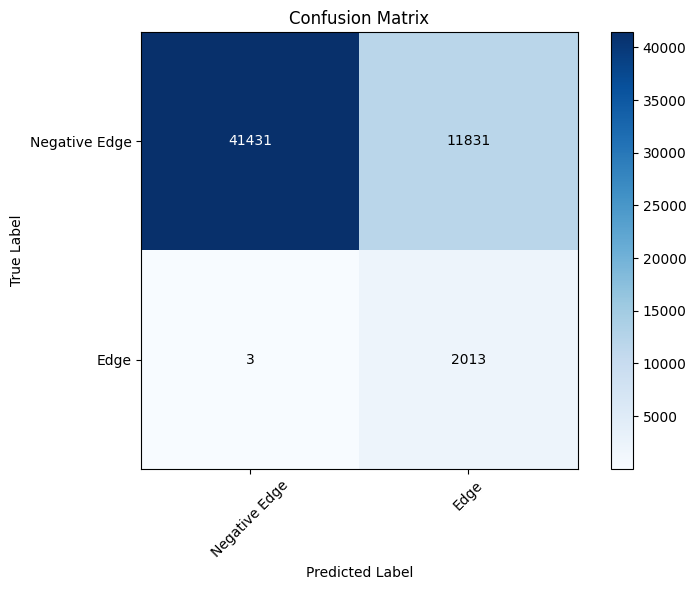

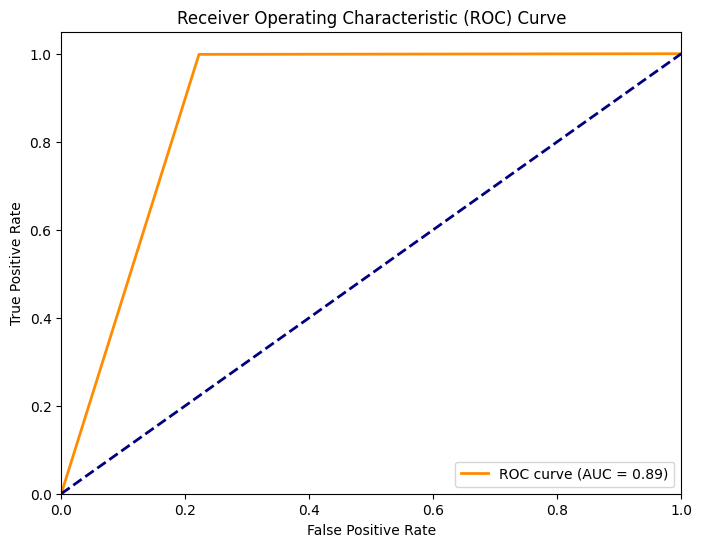

In [3]:
cf.plot_histogram(predictions)
cf.plot_confusion_matrix(predictions)
cf.plot_roc_curve(predictions)

In [4]:
nx_G = G.to_networkx()

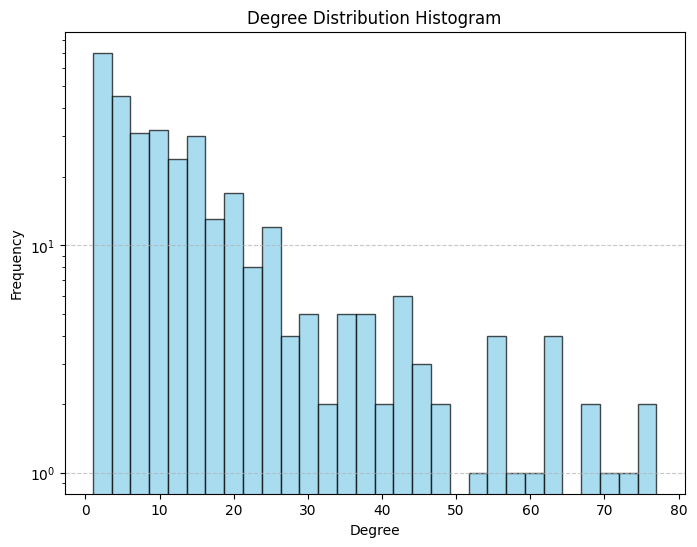

In [5]:
cf.plot_degree_distribution_log(nx_G)

c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

Best threshold: 0.6900000000000001, Best F1: 0.532604293236128


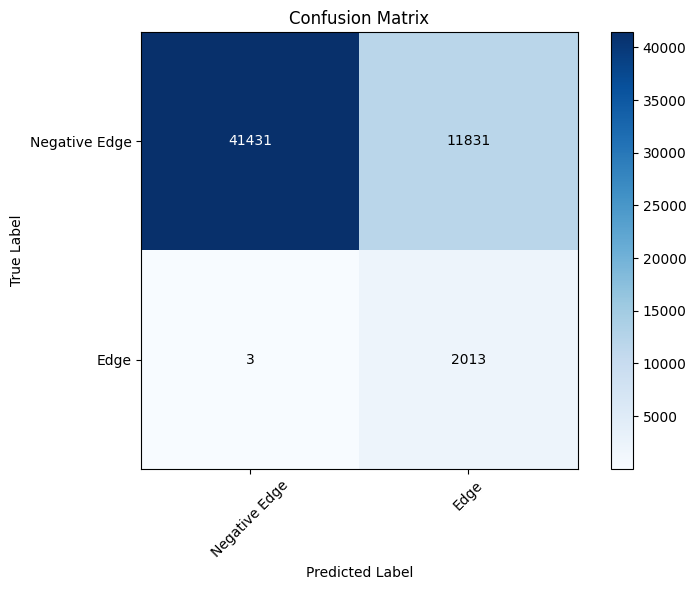

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# recall, precison, f1, accuracy = calculate_metrics(predictions)

best_threshold, best_f1 = cf.find_best_threshold(predictions)
print(f'Best threshold: {best_threshold}, Best F1: {best_f1}')


cf.plot_confusion_matrix(predictions, threshold = 0.5);

## Create Offers For Each User

In [7]:
predictions.head()

prob  pred_class  edge  pred_edge
first_node second_node                                       
0          1            0.691840           1   1.0          1
           2            0.500116           1   0.0          1
           3            0.754100           1   1.0          1
           4            0.635787           1   0.0          1
           5            0.570116           1   0.0          1

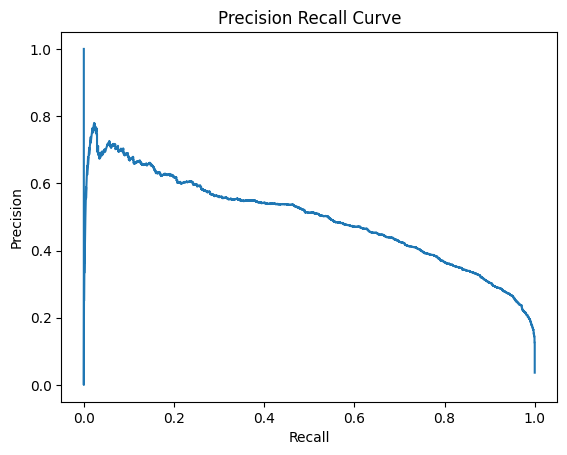

In [13]:


import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

plot_precision_recall_curve(predictions)

In [8]:
offers = predictions[(predictions['edge'] == 0) & (predictions['pred_edge'] == 1)].reset_index()

In [9]:
result_dict = {node: None for node in G.nodes()}
recommendation_number = 5

for node in G.nodes():
    filtered_offers = offers[(offers['first_node'] == node) | (offers['second_node'] == node)].copy()

    filtered_offers['neighbor'] = filtered_offers.apply(lambda x: x['first_node'] if x['first_node'] != node else x['second_node'], axis = 1).astype('int')

    result_dict[node] = list(filtered_offers.sort_values('prob', ascending = False)['neighbor'][:recommendation_number])

In [10]:
result_dict

{0: [40, 65, 91, 34, 8],
 56: [137, 122, 11, 86, 105],
 1: [60, 40, 107, 196, 296],
 22: [7, 105, 40, 101, 194],
 2: [129, 19, 80, 6, 88],
 80: [167, 2, 132, 88, 102],
 3: [34, 107, 14, 101, 137],
 115: [7, 40, 101, 196, 296],
 4: [40, 65, 60, 301, 34],
 107: [3, 40, 120, 29, 65],
 5: [214, 219, 183, 129, 19],
 131: [60, 47, 109, 56, 36],
 6: [208, 129, 2, 183, 124],
 47: [115, 196, 296, 7, 91],
 7: [36, 115, 69, 11, 136],
 84: [3, 34, 140, 69, 35],
 8: [86, 40, 65, 3, 56],
 223: [40, 65, 36, 60, 34],
 9: [40, 60, 56, 3, 101],
 36: [7, 65, 29, 105, 117],
 10: [3, 60, 109, 56, 34],
 95: [60, 36, 7, 40, 133],
 11: [56, 7, 34, 69, 89],
 31: [34, 69, 89, 71, 11],
 12: [7, 40, 3, 60, 36],
 13: [9, 3, 60, 115, 101],
 45: [3, 74, 193, 7, 47],
 14: [3, 105, 101, 107, 120],
 78: [60, 40, 34, 29, 56],
 15: [40, 69, 171, 84, 89],
 32: [88, 208, 144, 79, 124],
 16: [160, 145, 3, 7, 86],
 18: [101, 36, 40, 89, 10],
 17: [179, 200, 231, 230, 258],
 188: [298, 234, 238, 229, 231],
 34: [60, 3, 40, 31

In [11]:
chosen_node = 2

# Get the recommended nodes for the chosen node
recommendations = result_dict[chosen_node]

# Get the neighbors of the chosen node
neighbors = list(G.neighbors(chosen_node))

# Ez a rész nem kell, ezért kinullázom
recommendation_neighbors = []
for node in recommendations:
    t = list(G.neighbors(node))
    recommendation_neighbors += t

recommendation_neighbors = []

# Create a set of nodes in the subgraph
subgraph_nodes = set(recommendation_neighbors + recommendations + neighbors + [chosen_node])

# Create a subgraph from the set of nodes
subgraph = G.subgraph(list(subgraph_nodes)).to_networkx()

new_edges = [(chosen_node, recommendation) for recommendation in recommendations]

subgraph.add_edges_from(new_edges)

# Compute positions for the entire subgraph
pos = nx.spring_layout(subgraph)

# Define colors for nodes
node_colors = {
    **{n: 'green' for n in neighbors},           # Neighbor nodes color
    **{n: 'blue' for n in recommendation_neighbors},  # Neighbors of neighbors color
    **{n: 'yellow' for n in recommendations},   # Recommended nodes color
    chosen_node: 'red'            # Chosen node color
}

# Create nodes and edges for plotly
edge_trace_yellow = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='yellow'),  # Specify the edge color as yellow
    hoverinfo='none',
    mode='lines')

edge_trace_blue = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='green'),  # Specify the edge color as yellow
    hoverinfo='none',
    mode='lines')


edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])


    if (edge[0] == chosen_node) and (edge[1] in recommendations) or (edge[1] == chosen_node) and (edge[0] in recommendations):
        edge_trace_yellow['x'] += tuple([x0, x1, None])  # Add to the yellow edge trace
        edge_trace_yellow['y'] += tuple([y0, y1, None])  # Add to the yellow edge trace

    elif (edge[0] == chosen_node) and (edge[1] in neighbors) or (edge[1] == chosen_node) and (edge[0] in neighbors):
        edge_trace_blue['x'] += tuple([x0, x1, None])  # Add to the yellow edge trace
        edge_trace_blue['y'] += tuple([y0, y1, None])  # Add to the yellow edge trace

    else:
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

for node in subgraph.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([f'Node: {node}'])

# Create the plotly figure with both edge traces
fig = go.Figure(
    data=[edge_trace_yellow, edge_trace_blue, edge_trace, node_trace],
    layout=go.Layout(
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=0),
    )
)

# Update the node colors
fig.update_traces(marker=dict(color=[node_colors[node] for node in subgraph.nodes()]))

# Show the interactive plot
plot(fig, filename='interactive_network.html')

print("Chosen Node:", chosen_node)
print('Neighbor Nodes:', neighbors)
print('Recommendation Nodes:', result_dict[chosen_node])

Chosen Node: 2
Neighbor Nodes: [214, 50, 124, 178, 132, 144, 167, 116, 183, 208, 88, 32, 119, 80, 219]
Recommendation Nodes: [129, 19, 80, 6, 88]
